In [1]:
import os 
import warnings 
warnings.filterwarnings('ignore')
from glob import glob 
from tqdm import tqdm 
import pickle 
import time 

import pandas as pd 
import numpy as np 
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score,roc_curve,auc,precision_score,recall_score,f1_score

import torch 
import torch.nn as nn  
from torch import Tensor
from torch.utils.data import Dataset,DataLoader 
from torch import optim 

from src.model import Discriminator,Generator,weights_init
from src.Dataset import SwatDataset
from src.Options import OPT

In [2]:
with open('./Data/pre_data2.pickle','rb') as f:
    data = pickle.load(f)
opt = OPT()
opt.ndf = 32 
train_set = SwatDataset(data,'train')
test_set = SwatDataset(data,'test')
train_loader = DataLoader(train_set,batch_size=opt.batchsize,shuffle=True)
test_loader = DataLoader(test_set,batch_size=opt.batchsize,shuffle=True)

In [6]:
len(a)

[tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.7340, 0.7285, 0.7214,  ..., 0.0000, 0.0000, 0.0000],
          [0.5000, 0.5000, 0.5000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [1.0000, 1.0000, 1.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [1.0000, 1.0000, 1.0000,  ..., 0.0000, 0.0000, 0.0000]],
 
         [[0.9147, 0.9795, 0.9539,  ..., 0.0000, 0.0000, 0.0000],
          [0.5128, 0.5182, 0.5218,  ..., 0.0000, 0.0000, 0.0000],
          [1.0000, 1.0000, 1.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [1.0000, 1.0000, 1.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [1.0000, 1.0000, 1.0000,  ..., 0.0000, 0.0000, 0.0000]],
 
         [[0.9297, 0.9624, 0.9595,  ..., 0.0000, 0.0000, 0.0000],
          [0.4396, 0.4404, 0.4407,  ..., 0.5339, 0.5274, 0.5217],
          [1.0000, 1.0000, 1.0000,  ...,

In [23]:
def predict(dataloader,G,D,opt,scale=True):
    device = opt.device
    G.eval()
    D.eval()
    with torch.no_grad():

        an_scores = torch.zeros(size=(len(dataloader.dataset),), dtype=torch.float32, device= device)
        gt_labels = torch.zeros(size=(len(dataloader.dataset),), dtype=torch.long,    device= device)
        #dis_feat = torch.zeros(size=(len(dataloader.dataset),  opt.ndf*16*10), dtype=torch.float32,device= device)


        for i, (batch_x,batch_y) in enumerate(dataloader):
            batch_x,batch_y = batch_x.type(torch.float32).to(device),batch_y.type(torch.float32).to(device)
            fake, latent_i =  G(batch_x)
            # error = torch.mean(torch.pow((d_feat.view( input.shape[0],-1)-d_gen_feat.view( input.shape[0],-1)), 2), dim=1)
            #
            error = torch.mean(
                torch.pow(( batch_x.view(batch_x.shape[0], -1) -  fake.view( fake.shape[0], -1)), 2),
                dim=1) # reconstruction loss 


            gt_labels[i* opt.batchsize : i* opt.batchsize+error.size(0)] = torch.max(batch_y,dim=1).values.reshape(error.size(0)) #y 
            an_scores[i* opt.batchsize : i* opt.batchsize+error.size(0)] = error.reshape(error.size(0)) #y_pred
            
        # Scale error vector between [0, 1]
        if scale:
             an_scores = (an_scores - torch.min(an_scores)) / (torch.max(an_scores) - torch.min(an_scores))

        y_= gt_labels.detach().cpu().numpy()
        y_pred = an_scores.detach().cpu().numpy()

        return y_,y_pred
#def evaluate(train_loader,test_loader):
def evaluate(train_loader,test_loader,G,D,THRES=99):
    train_y,train_y_pred = predict(train_loader,G,D,opt)
    test_y,test_y_pred = predict(test_loader,G,D,opt)
    thres = np.percentile(np.concatenate([train_y,train_y_pred]),THRES)
    
    
    y_pred_thres = pd.Series(test_y_pred).apply(lambda x : 1 if x > thres else 0).values
    #auc = accuracy_score(y,y_pred)
    precision, recall, f_score, support = precision_recall_fscore_support(test_y, y_pred_thres,
                                                                                average='binary')
    fpr,tpr,thr = roc_curve(test_y,test_y_pred)
    auroc = auc(fpr,tpr)
    
    return precision, recall, f_score, auroc

In [29]:
#def model_load():
device = 'cuda:0'

D = torch.load('/data/IITP/BeatGAN_mine2/save_models/Base01/D.pt').to(device)
G = torch.load('/data/IITP/BeatGAN_mine2/save_models/Base01/G.pt').to(device)

In [37]:
precision, recall, f_score, auroc = evaluate(train_loader,test_loader,G,D,THRES=50)
print(precision, recall, f_score, auroc)

0.28148508551966767 1.0 0.4393107476635514 0.6086076400558267


(array([8.8634e+04, 4.3000e+02, 2.2077e+04, 1.8402e+04, 6.9300e+02,
        8.2000e+01, 7.3000e+01, 8.1000e+01, 1.3200e+02, 2.9920e+03]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ],
       dtype=float32),
 <BarContainer object of 10 artists>)

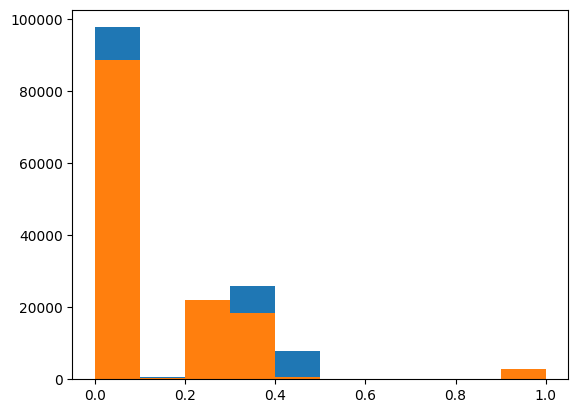

In [35]:
import matplotlib.pyplot as plt 

plt.hist(y_pred)
plt.hist(test_y_pred)

In [63]:
mse_criterion = nn.MSELoss()
G.eval()
an_score = [] # y_pred 
gt_label = [] # y 
for batch_x,batch_y in test_loader:
    batch_x,batch_y = batch_x.type(torch.float32).to(device),batch_y.type(torch.float32).to(device)
    
    #inference 
    with torch.no_grad():
        fake,latent_i = G(batch_x)
    err = torch.mean(torch.mean(((batch_x - fake)**2),dim=1),dim=1) #an score 
    
    #save 
    an_score.extend(err.detach().cpu().numpy())
    gt_label.extend(torch.max(batch_y,dim=1).values.detach().cpu().numpy())
    
an_score = (np.array(an_score)-np.min(an_score))/(np.max(an_score)-np.min(an_score))
gt_label = np.array(gt_label)
test_y,test_y_pred = gt_label,an_score

In [ ]:
from src.metric import evaluate
auc_prc,roc_auc,best_threshold,best_f1 = evaluate(test_y,test_y_pred)

In [ ]:
thres = 0.05
y_pred = pd.Series(test_y_pred).apply(lambda x : 1 if x > thres else 0)
results = [] 
for metric in [recall_score,precision_score,f1_score]:
    results.append(metric(test_y,y_pred))
print(results)